In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

In [4]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [5]:
print(data.describe())
num_cells = data.shape[0]
num_features = data.shape[1]

print(f"Количество треков: {num_cells}")
print(f"Количество признаков: {num_features}")

         Popularity  danceability        energy           key      loudness  \
count  17568.000000  17996.000000  17996.000000  15982.000000  17996.000000   
mean      44.512124      0.543433      0.662777      5.952447     -7.910660   
std       17.426928      0.166268      0.235373      3.196854      4.049151   
min        1.000000      0.059600      0.000020      1.000000    -39.952000   
25%       33.000000      0.432000      0.509000      3.000000     -9.538000   
50%       44.000000      0.545000      0.700000      6.000000     -7.016000   
75%       56.000000      0.659000      0.860000      9.000000     -5.189000   
max      100.000000      0.989000      1.000000     11.000000      1.355000   

               mode   speechiness  acousticness  instrumentalness  \
count  17996.000000  17996.000000  17996.000000      13619.000000   
mean       0.636753      0.079707      0.247082          0.177562   
std        0.480949      0.083576      0.310632          0.304048   
min        0

In [6]:
def detect_variable_types(df):
  variable_types = {'categorical': [], 'numerical': []}
  for column in df.columns:
    if df[column].dtype == 'object':
      variable_types['categorical'].append(column)
    elif df[column].dtype in [np.int64, np.float64]:
      variable_types['numerical'].append(column)
  return variable_types
variables = detect_variable_types(data)
variables

{'categorical': ['Artist Name', 'Track Name'],
 'numerical': ['Popularity',
  'danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence',
  'tempo',
  'duration_in min/ms',
  'time_signature',
  'Class']}

In [7]:
def count_missing_values(df):
  missing_values = {}
  for column in df.columns:
    missing_values[column] = df[column].isnull().sum()
  return missing_values
miss_values = count_missing_values(data)
print(miss_values)

{'Artist Name': 0, 'Track Name': 0, 'Popularity': 428, 'danceability': 0, 'energy': 0, 'key': 2014, 'loudness': 0, 'mode': 0, 'speechiness': 0, 'acousticness': 0, 'instrumentalness': 4377, 'liveness': 0, 'valence': 0, 'tempo': 0, 'duration_in min/ms': 0, 'time_signature': 0, 'Class': 0}


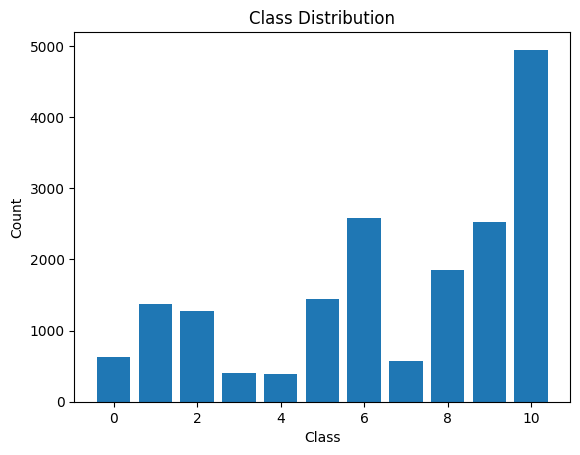

In [8]:
class_counts = np.bincount(data['Class'].astype(int))
plt.bar(np.arange(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show() #как же много болливуда, ладно, почти половина датасета

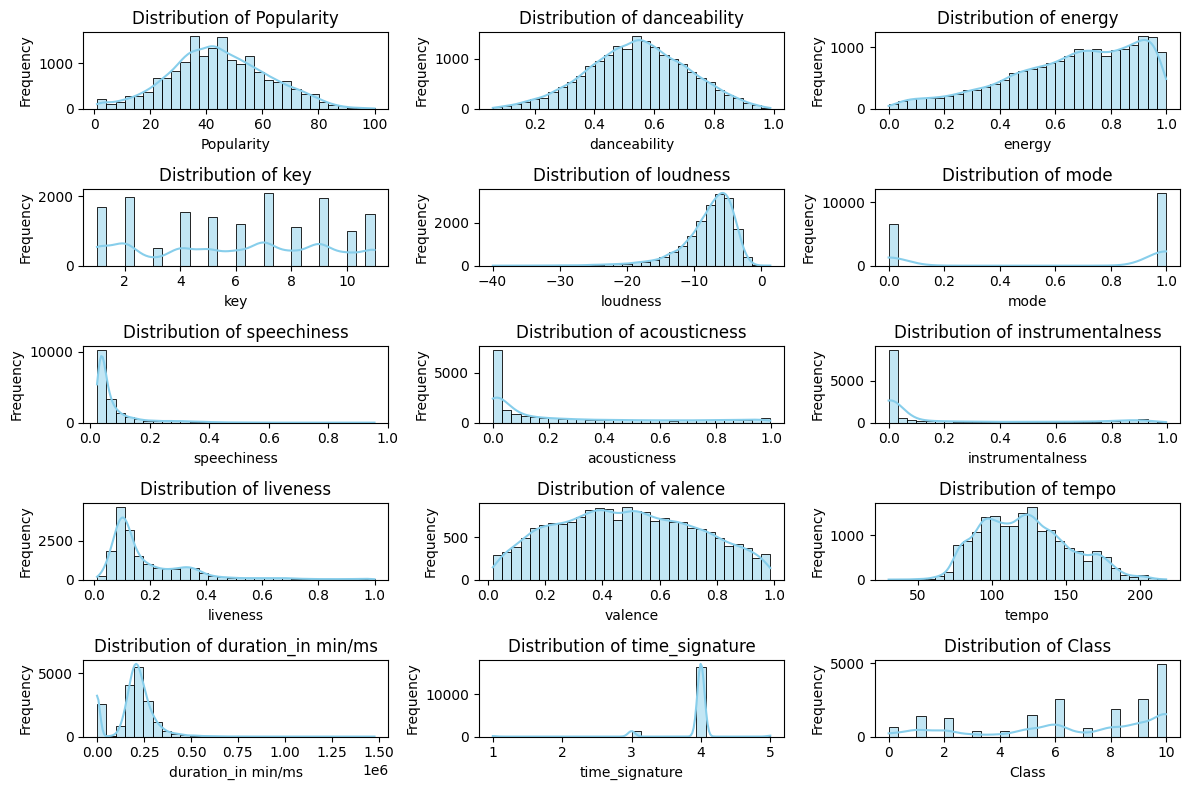

In [9]:
numerical_columns = variables['numerical']
plt.figure(figsize=(12, 8))
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols
for i, column in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(data[column], bins=30, color='skyblue', kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show() #правда смотря на это mode, key, time_signature это категориальные тоже, но я удалю максимумы и минимумы в нескольких местах в численных

In [10]:
data_clean = data.drop(labels=[np.argmax(data['duration_in min/ms']), 
                                     np.argmax(data['liveness']), 
                                     np.argmax(data['instrumentalness']),
                                     np.argmin(data['loudness'])], axis=0, inplace=False)

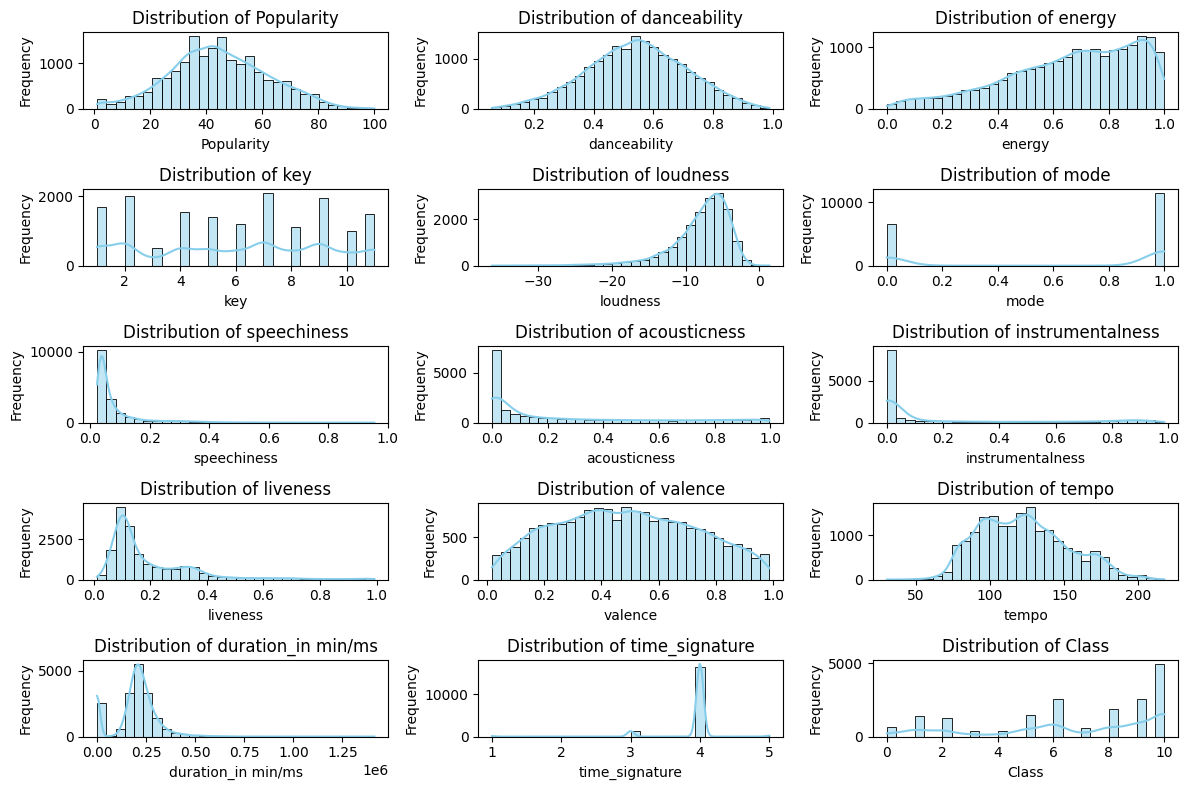

In [11]:
numerical_columns = variables['numerical']
plt.figure(figsize=(12, 8))
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols
for i, column in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(data_clean[column], bins=30, color='skyblue', kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show() #не очень помогло, видимо связано с тем, что в жанрах музыки дисбаланс

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [12]:
#я убрала какие-то точки, но перед тем, как обучать модель, уберу еще колонки с именем трека и группы
X = data_clean.drop(columns=['Artist Name', 'Track Name', 'Class'])
X.head()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4
3,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4
4,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4


In [13]:
y = data_clean.iloc[:, -1]
print(y)

0         5
1        10
2         6
3         5
4        10
         ..
17991     6
17992     2
17993     8
17994     8
17995    10
Name: Class, Length: 17992, dtype: int64


In [14]:
categorical_features = ['key', 'mode', 'time_signature'] 
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])
preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features)
])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [15]:
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__class_weight': ['balanced', None]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X, y)
best_params = grid_search.best_params_

In [16]:
print(best_params)
max_depth = best_params['classifier__max_depth']
min_samples_leaf = best_params['classifier__min_samples_leaf']
min_samples_split = best_params['classifier__min_samples_split']
class_weight = best_params['classifier__class_weight']
criterion = best_params['classifier__criterion']

{'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
tree_clf = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, class_weight = class_weight)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [19]:
y_pred = tree_clf.predict(X_test)
print(f'accuracy = {balanced_accuracy_score(y_test, y_pred)}\nf1 = {f1_score(y_test, y_pred, average = 'macro')}')
#я выбрала метрики с учетом того, что классы не сбалансированные, не очень конечно вышло, но танцы с бубнами больше ничего не дают
#я еще джини коэффициент хотела использовать, он был в метриках скалерна, но почему-то у меня не находит его, хотя в документации он был

accuracy = 0.45669242637508156
f1 = 0.4468190125589137


### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Рик и Морти - очень люблю, супер интересно, последние сезоны так вообще

2. Аватар Аанг - все из-за Мэй и Зуко, хочу такие же отношения

3. Комиксы считаются? Тогда чумной доктор. Судя по такому списку я очень люблю тропы "стоит ли месть того"